In [30]:
# get the relevant dependencies 
import json
import os
import sys 
import random
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from event_model import event_model as em

# resource switch
dataset={
    'small':'events/small_dataset',
    'bsphiphi': 'events/bsphiphi',
    'minibias': 'events/minibias'
}


In [48]:
# analysis variables
DATASET = 'bsphiphi'
load_percent = 0.1 
shuffle = True

In [49]:
# read in the events -> from the folder choosen 
loaded_events = []
for (dirpath, dirnames, filenames) in os.walk(os.path.abspath(os.path.join('..', dataset[DATASET]))):
    if shuffle:
        random.shuffle(filenames)

    for i, filename in enumerate(filenames):
        # Get an event
        f = open(os.path.realpath(os.path.join(dirpath, filename)))
        json_data = json.loads(f.read())
        loaded_events = loaded_events + [em.event(json_data)]
        f.close()
        
        if i == int(load_percent * len(filenames)):
            print(f'successfully loaded {i} events')
            break


successfully loaded 100 events


In [88]:
# is the distance beween the parts of one module always the same?
# is this the thickness of the module (why are there some hits on one side and some on the othere?)
event = loaded_events[30] # take the first of the elements for this check

z_modules = np.zeros(shape=(5,52))

print(len(event.module_zs))
for idx, module in enumerate(event.module_zs):
    #print(list(module)[0]-list(module)[1])
    z_modules[0,idx] = idx
    z_modules[1,idx] = min(module)
    z_modules[2,idx] = max(module)
    z_modules[3,idx] = max(module) - min(module)
    z_modules[4,idx] = 0
    # pretty damn the same
for i in range(1,52):
    z_modules[4,i] = z_modules[1,i] - z_modules[1,i-1]

print(pd.DataFrame(z_modules.T, columns = [['module id', 'z1', 'z2', 'z2-z1', ' dist(i-1, i)']]))
#pd.DataFrame(z_modules.T, columns = [['module id', 'z1', 'z2', 'z2-z1', ' dist(i-1, i)']]).to_csv('module_information.csv')

52
   module id       z1       z2  z2-z1  dist(i-1, i)
0        0.0 -288.080 -286.918  1.162         0.000
1        1.0 -275.580 -274.418  1.162        12.500
2        2.0 -263.080 -261.918  1.162        12.500
3        3.0 -250.580 -249.418  1.162        12.500
4        4.0 -238.080 -236.918  1.162        12.500
5        5.0 -225.580 -224.418  1.162        12.500
6        6.0 -213.080 -211.918  1.162        12.500
7        7.0 -200.580 -199.418  1.162        12.500
8        8.0 -138.080 -136.918  1.162        62.500
9        9.0 -125.580 -124.418  1.162        12.500
10      10.0  -63.080  -61.918  1.162        62.500
11      11.0  -50.580  -49.418  1.162        12.500
12      12.0  -38.080  -36.918  1.162        12.500
13      13.0  -25.580  -24.418  1.162        12.500
14      14.0  -13.080  -11.918  1.162        12.500
15      15.0   -0.580    0.581  1.161        12.500
16      16.0   11.919   13.081  1.162        12.499
17      17.0   24.419   25.581  1.162        12.500
18      1

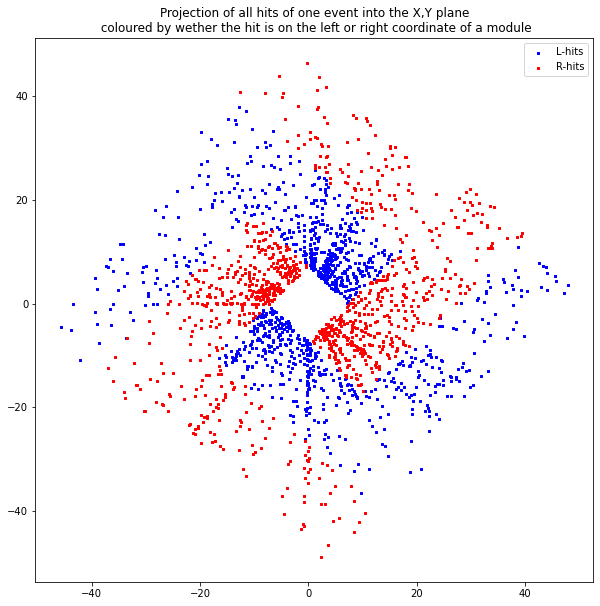

In [89]:
import numpy as np
import matplotlib.pyplot as plt

left_hits = []
right_hits = []

for module_number in range(52):
    l1 = min(event.modules[module_number].z)

    hit_coords = np.zeros(shape=(2,len(event.modules[module_number].hits())))
    is_left = []
    
    for i, hit in enumerate(event.modules[module_number].hits()):
        hit_coords[0,i] = hit.x
        hit_coords[1,i] = hit.y
        is_left.append(hit.z==l1)
    

    left_hits.append(hit_coords[:,is_left])    
    right_hits.append(hit_coords[:,[not e for e in is_left]])    

left_hits = np.concatenate(left_hits, axis=1)
right_hits = np.concatenate(right_hits, axis=1)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)


ax1.scatter(left_hits[0,:], left_hits[1,:], s=5, c='b', marker="s", label='L-hits')
ax1.scatter(right_hits[0,:], right_hits[1,:], s=5, c='r', marker="s", label='R-hits')
ax1.legend()
ax1.set_title('Projection of all hits of one event into the X,Y plane\n coloured by wether the hit is on the left or right coordinate of a module')
plt.show()

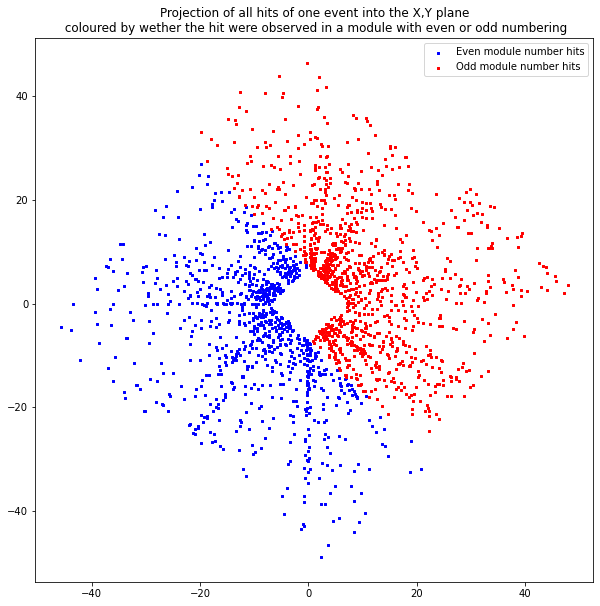

In [92]:
import numpy as np
import matplotlib.pyplot as plt

left_hits = []
right_hits = []

for module_number in range(52):
    l1 = min(event.modules[module_number].z)

    hit_coords = np.zeros(shape=(2,len(event.modules[module_number].hits())))
    is_even = []
    
    for i, hit in enumerate(event.modules[module_number].hits()):
        hit_coords[0,i] = hit.x
        hit_coords[1,i] = hit.y
        is_even.append(hit.module_number%2==0)
    

    left_hits.append(hit_coords[:,is_even])    
    right_hits.append(hit_coords[:,[not e for e in is_even]])    

left_hits = np.concatenate(left_hits, axis=1)
right_hits = np.concatenate(right_hits, axis=1)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)


ax1.scatter(left_hits[0,:], left_hits[1,:], s=5, c='b', marker="s", label='Even module number hits')
ax1.scatter(right_hits[0,:], right_hits[1,:], s=5, c='r', marker="s", label='Odd module number hits')
ax1.legend()
ax1.set_title('Projection of all hits of one event into the X,Y plane\n coloured by wether the hit were observed in a module with even or odd numbering')
plt.show()

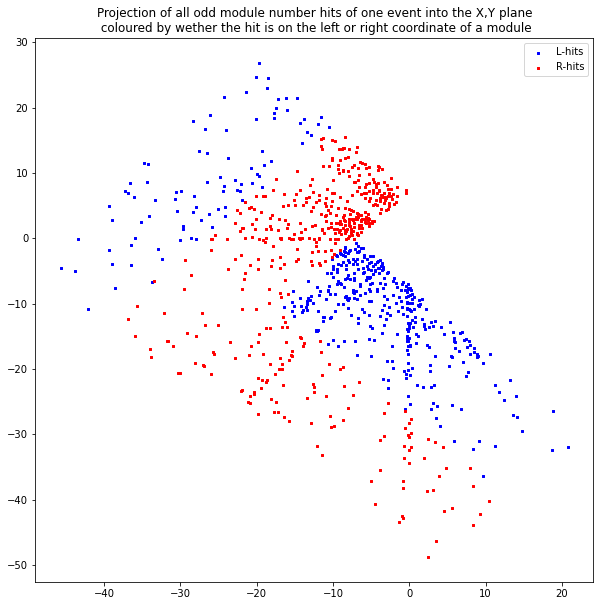

In [99]:
import numpy as np
import matplotlib.pyplot as plt

left_hits = []
right_hits = []

for module_number in range(52):
    l1 = min(event.modules[module_number].z)

    hit_coords = np.zeros(shape=(2,len(event.modules[module_number].hits())))
    is_left = []
    
    for i, hit in enumerate(event.modules[module_number].hits()):
        # change here!
        if hit.module_number%2==1:
            continue
        hit_coords[0,i] = hit.x
        hit_coords[1,i] = hit.y
        is_left.append(hit.z==l1)
    

    left_hits.append(hit_coords[:,is_left])    
    right_hits.append(hit_coords[:,[not e for e in is_left]])    

left_hits = np.concatenate(left_hits, axis=1)
right_hits = np.concatenate(right_hits, axis=1)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)


ax1.scatter(left_hits[0,:], left_hits[1,:], s=5, c='b', marker="s", label='L-hits')
ax1.scatter(right_hits[0,:], right_hits[1,:], s=5, c='r', marker="s", label='R-hits')
ax1.legend()
ax1.set_title('Projection of all odd module number hits of one event into the X,Y plane\n coloured by wether the hit is on the left or right coordinate of a module')
plt.show()

In [36]:
import math
# particle class to properly handle the real tracks -> might want to plot angles where we see the highest density
class particle(object):
    def __init__(self, particle, event):
        self.key = particle[0]
        self.pid = particle[1]
        self.p = particle[2]
        self.pt = particle[3]
        self.eta = particle[4]
        self.phi = particle[5]
        self.isLong = particle[6]
        self.isDown = particle[7]
        # always true
        self.hasVelo = particle[8]
        self.hasUT = particle[9]
        self.hasScifi = particle[10]
        #self.fromBeautyDecay = particle[11]
        #self.fromCharmDecay = particle[12]
        #self.fromStrangeDecay = particle[13]
        self.charge = particle[14]
        self.hits = particle[15]
        self.track = [hit for hit in event.hits if hit.id in self.hits]
        self.is_decay = any([particle[11], particle[12], particle[13]])
        self.is_noise = len(self.track) < 3
        # compare dist of 2 points to center
        self.left_to_right = (math.sqrt(self.track[0].x**2 * self.track[0].y**2) < math.sqrt(self.track[1].x**2 * self.track[1].y**2))

def give_track_coords(self):
    coords = np.zeros(shape=(2,len(self.track)))
    for i, hit in enumerate(self.track):
        coords[0,i] = hit.x
        coords[1,i] = hit.y 
    return coords

In [37]:
def give_track_coords(particle):
    coords = np.zeros(shape=(2,len(particle.track)))
    for i, hit in enumerate(particle.track):
        coords[0,i] = hit.x
        coords[1,i] = hit.y 
    return coords

In [38]:
all_event_particles = []
hits_to_remove = []
all_track_hits = []

for part in event.montecarlo.get('particles'):
    temp_particle = particle(part, event)
    all_event_particles = all_event_particles + [temp_particle]
    for hit in temp_particle.track:
        hits_to_remove.append(hit.id)
    all_track_hits = all_track_hits + temp_particle.track

noise_hits = [hit for hit in event.hits if hit.id not in hits_to_remove]
noise_coords = np.zeros(shape=(2,len(noise_hits)))
for i, hit in enumerate(noise_hits):
    noise_coords[0,i]= hit.x
    noise_coords[1,i]= hit.y

track_hit_coords = np.zeros(shape=(2, len(all_track_hits))) 
for i, hit in enumerate(all_track_hits):
    track_hit_coords[0,i] = hit.x
    track_hit_coords[1,i] = hit.y


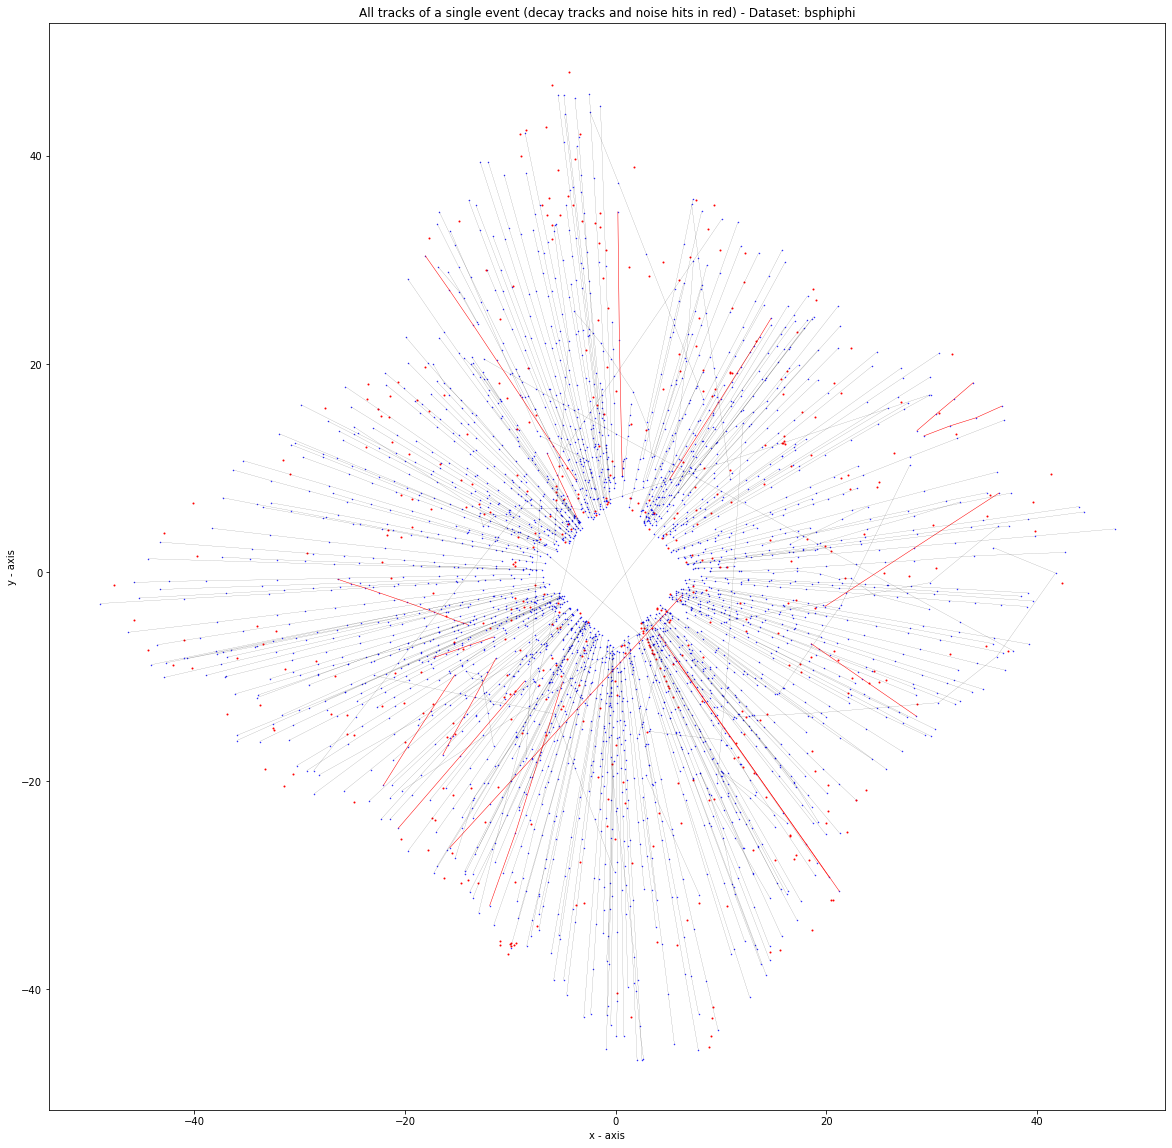

In [103]:
# now its getting funny
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
ax  = fig.add_subplot(111)

for particle in all_event_particles:
    coords = give_track_coords(particle)
    color = 'black'
    width = 0.1
    label = 'particle track'
    if particle.is_decay:
        width = 0.5
        color='red'
        label = 'decay track'
    ax.plot(coords[0], coords[1], linewidth=width, color=color, markeredgewidth=2, label = label)
ax.scatter(track_hit_coords[0],track_hit_coords[1], s=0.2, c ='b')
ax.scatter(noise_coords[0],noise_coords[1], s=1, c='r')

ax.set_xlabel('x - axis')
# Set the y axis label of the current axis.
ax.set_ylabel('y - axis')
# Set a title of the current axes.
ax.set_title(f'All tracks of a single event (decay tracks and noise hits in red) - Dataset: {DATASET}')
# show a legend on the plot
#ax.legend()
# Display a figure.
plt.show()

In [54]:
# Lets analyse angles of the particles (distribution of this)
all_particles = all_event_particles
all_angles = []
num_hits = []
print(f'number of particles were looking at {len(all_particles)}')

for particle in all_particles:
    all_angles = all_angles + [particle.phi]
    num_hits = num_hits + [len(particle.track)]

number of particles were looking at 435


In [57]:
import math

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))


0.27586206896551724


(array([ 8.,  7., 12., 12., 21., 24.,  9.,  5.,  6.,  7.,  0., 13., 18.,
        18., 14., 23., 18., 21., 19., 15.,  0., 13.,  7.,  3.,  7., 12.,
        11.,  0.,  9.,  8.,  8.,  0.,  6.,  5.,  5.,  7.,  3.,  5.,  4.,
         7.,  3.,  0., 10.,  4.,  9.,  7.,  6.,  4.,  0.,  1.,  0.,  1.]),
 array([ 4.        ,  4.90384615,  5.80769231,  6.71153846,  7.61538462,
         8.51923077,  9.42307692, 10.32692308, 11.23076923, 12.13461538,
        13.03846154, 13.94230769, 14.84615385, 15.75      , 16.65384615,
        17.55769231, 18.46153846, 19.36538462, 20.26923077, 21.17307692,
        22.07692308, 22.98076923, 23.88461538, 24.78846154, 25.69230769,
        26.59615385, 27.5       , 28.40384615, 29.30769231, 30.21153846,
        31.11538462, 32.01923077, 32.92307692, 33.82692308, 34.73076923,
        35.63461538, 36.53846154, 37.44230769, 38.34615385, 39.25      ,
        40.15384615, 41.05769231, 41.96153846, 42.86538462, 43.76923077,
        44.67307692, 45.57692308, 46.48076923, 47

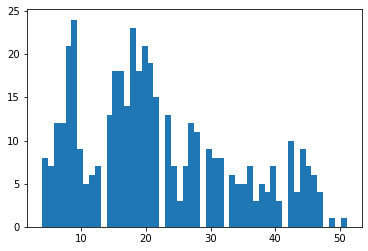

In [59]:
import matplotlib.pyplot as plt
################ getting the first and last hit of all the ###################
# i define origin hit as the one with closest distance to z axis
# i define the last hit as the one with furtherst distance from the z axis
# i guess i only need to look at the first and last hit of one particle -> have not seen smth else
min_hits = []
max_hits = []
count_reverse = 0
for particle in all_particles:
    hit1 = particle.track[0]    
    hit2 = particle.track[-1]
    
    if math.sqrt(hit1.x**2 + hit1.y**2) < math.sqrt(hit2.x**2 + hit2.y**2):

        min_hits = min_hits + [hit1]
        max_hits = max_hits + [hit2]
    else:
        # this happens
        min_hits = min_hits + [hit2]
        max_hits = max_hits + [hit1]
        count_reverse += 1
    
print(count_reverse/len(min_hits))

############## hist the distr of closest and furthest hits #############

plt.hist([hit.module_number for hit in min_hits], bins = 52)


(array([46., 38.,  4.,  5.,  8.,  2.,  2.,  1.,  2.,  2.,  3.,  4.,  1.,
         0.,  0.,  0.,  0.,  3.,  4.,  5.,  9.,  4.,  8.,  4.,  6.,  4.,
         6.,  7.,  8.,  7.,  2.,  5.,  4.,  7.,  1.,  2., 10.,  7., 14.,
         8., 13.,  7.,  8.,  7.,  7.,  2.,  4.,  7.,  5.,  4., 65., 53.]),
 array([ 0.        ,  0.98076923,  1.96153846,  2.94230769,  3.92307692,
         4.90384615,  5.88461538,  6.86538462,  7.84615385,  8.82692308,
         9.80769231, 10.78846154, 11.76923077, 12.75      , 13.73076923,
        14.71153846, 15.69230769, 16.67307692, 17.65384615, 18.63461538,
        19.61538462, 20.59615385, 21.57692308, 22.55769231, 23.53846154,
        24.51923077, 25.5       , 26.48076923, 27.46153846, 28.44230769,
        29.42307692, 30.40384615, 31.38461538, 32.36538462, 33.34615385,
        34.32692308, 35.30769231, 36.28846154, 37.26923077, 38.25      ,
        39.23076923, 40.21153846, 41.19230769, 42.17307692, 43.15384615,
        44.13461538, 45.11538462, 46.09615385, 47

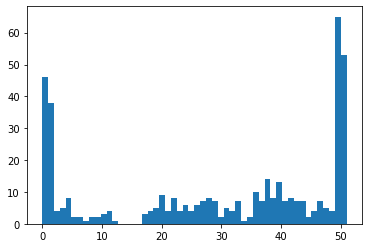

In [60]:
plt.hist([hit.module_number for hit in max_hits], bins = 52)

In [61]:
################ checking how many tracks cross the beam line ##################
################ also checking how many tracks dont have consecutive triplets ##########
# the consecutive thing is really not nice
beam_crossing_particles = []
no_cosecutive_triplet = []

# id say we have a beam cross if either x or y change sign among hits
for particle in all_particles:
    x_p, x_n, y_p, y_n, = False, False, False, False
    triplet = 0
    last_module = -2
    for hit in particle.track:
        x_p = hit.x >0 or x_p
        x_n = hit.x <0 or x_n
        y_p = hit.y >0 or y_p
        y_n = hit.y <0 or y_n
        
        if triplet < 3:
            if hit.module_number in (last_module + 1,last_module + 1):
                triplet += 1
                last_module = hit.module_number
            else:
                triplet = 1
                last_module = hit.module_number
                
    if x_p + x_n + y_p + y_n > 2:
        beam_crossing_particles = beam_crossing_particles + [particle]
    if triplet < 3:
        no_cosecutive_triplet = no_cosecutive_triplet + [particle]
print(len(all_particles))
print('beam_crossing')
print(len(beam_crossing_particles))
print(len(beam_crossing_particles)/len(all_particles))
print('no_co')
print(len(no_cosecutive_triplet))
print(len(no_cosecutive_triplet)/len(all_particles))


# 5% of the tracks seem to cross the line

435
beam_crossing
20
0.04597701149425287
no_co
435
1.0


In [63]:
decay = 0
for particle in all_particles:
    if particle.is_decay:
        decay +=1
print(decay)
# abput 5% of particles from decay

17


In [64]:
decay = 0
for particle in beam_crossing_particles:
    if particle.is_decay:
        decay +=1
print(decay)
# ~20%

#775 -> 132

2


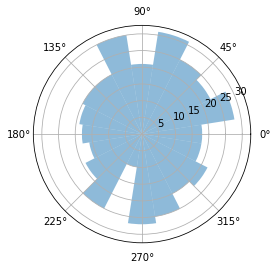

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# discard ?!
############### I cant tell if this plots the angles correctly #########
# I think its correct because we get such a nice distribution

bins_number = 20  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
angles = [(np.pi + angle) for angle in all_angles]
n, _, _ = plt.hist(angles, bins)

plt.clf()
width = 2 * np.pi / bins_number
ax = plt.subplot(1, 1, 1, projection='polar')
bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0)
for bar in bars:
    bar.set_alpha(0.5)
plt.show()

In [69]:
from sklearn.linear_model import LinearRegression

def track_regression_analysis(particle):
    my_arr = np.zeros((len(particle.track),2))
    z = np.zeros((len(particle.track),1))
    for i, hit in enumerate(particle.track):
        my_arr[i,0] = hit.x        
        my_arr[i,1] = hit.y
        z[i] = hit.z
        
    x_reg = LinearRegression().fit(z,my_arr[:,0])
    y_reg = LinearRegression().fit(z,my_arr[:,1])
    
    dev_hit = particle.track[0]
    x_pred = x_reg.predict(np.array([dev_hit.z]).reshape(-1, 1))
    y_pred = y_reg.predict(np.array([dev_hit.z]).reshape(-1, 1))
    pred = (x_pred,y_pred)
    
    max_dev_hit = math.sqrt((x_pred[0]-dev_hit.x)**2 + (y_pred[0]-dev_hit.y)**2)
    max_angle = 0
    last_hit = dev_hit
    
    for hit in particle.track[1:]:
        x_pred = x_reg.predict(np.array([hit.z]).reshape(-1, 1))
        y_pred = y_reg.predict(np.array([hit.z]).reshape(-1, 1))
        new_deviation = math.sqrt((x_pred[0]-hit.x)**2 + (y_pred[0]-hit.y)**2)
        print()
        new_angle = angle((x_reg.coef_, y_reg.coef_,1), (hit.x-last_hit.x,hit.y-last_hit.y,hit.z-last_hit.z))
        if new_deviation >  max_dev_hit:
            max_dev_hit = new_deviation
            dev_hit = hit
            pred = (x_pred,y_pred)
            
        if new_angle > max_angle:
            max_angle = new_angle
            
        last_hit = hit
    return max_dev_hit, hit, pred, max_angle
    

print(track_regression_analysis(all_particles[0]))
    














(0.047122352365929196, #3312 module 51 {18.095, 12.802, 750.581}, (array([4.54117598]), array([3.3125221])), 0.030147190314535485)
